# Part 3.1: Policy-Based Dynamic Programming

In this notebook, we'll learn **Policy-Based Dynamic Programming** methods for solving MDPs. These are **model-based** methods that require complete knowledge of the environment.

## Recap from Part 2
- **MDPs** consist of states, actions, transition probabilities P, rewards R, and discount factor γ
- **Policies** π(a|s) specify how the agent chooses actions (deterministic or stochastic)
- **Value functions** V^π(s) and Q^π(s,a) quantify long-term expected return
- **Bellman equations** decompose values into immediate reward + discounted future value
- **Optimal value functions** V* and Q* correspond to the best possible policy π*

## What This Notebook Covers
- What is Dynamic Programming?
- Policy Evaluation (computing $V^\pi$)
- Policy Improvement (making policy better)
- Policy Iteration (evaluation + improvement)

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Value Iteration** | Covered in notebook 03_2. Value Iteration uses the Bellman optimality equation directly instead of alternating between evaluation and improvement. | Policy Iteration fully evaluates each policy before improving. Value Iteration combines evaluation and improvement into a single step, which can be more efficient. |
| **Model-free methods** | This notebook focuses on model-based RL where we know the MDP dynamics (transition probabilities and rewards). Model-free methods come in the next notebooks. | We assume perfect knowledge of P and R, allowing us to compute exact value functions. Model-free methods like Monte Carlo and TD learning work without this knowledge — they learn from experience instead of computation. |
| **Deep reinforcement learning** | Deep RL uses neural networks to approximate value functions for high-dimensional state spaces. We start with tabular methods where we can store exact values for each state. | In this notebook, we maintain tables V[s] and Q[s,a] for all states/actions (feasible for FrozenLake's 16 states). Deep RL uses neural networks f(s;θ) to handle millions of states like images — a fundamentally different approach. |
| **Asynchronous dynamic programming** | Standard DP updates all states in sweeps. Asynchronous DP updates states in any order, which can be more efficient but adds complexity. | We use synchronous updates: update all states in each iteration. Asynchronous DP (prioritized sweeping, real-time DP) updates states strategically, which is more efficient but requires understanding the basics first. |

## Preview: Policy-Based Dynamic Programming Algorithms

Now that we understand MDPs and Bellman equations, we can use them to **find optimal policies**! Policy-based Dynamic Programming gives us algorithms to solve RL problems:

- **Policy Evaluation**: Given a policy, compute its value function V^π
- **Policy Improvement**: Given V^π, find a better policy by acting greedily
- **Policy Iteration**: Alternate evaluation and improvement until convergence
- **All require knowing the MDP model** (that's why they're "model-based")

The magic: These algorithms are **guaranteed to find the optimal policy** for any MDP!

## How to Read This Notebook
1. **Theory and algorithms**: Each section introduces a DP algorithm (policy evaluation, policy improvement, policy iteration) with mathematical foundations
2. **Step-by-step implementations**: Run the code cells to see each algorithm solve FrozenLake from scratch
3. **Visualizations**: Plots show how value functions and policies evolve during learning

Let's begin!

## Prerequisites
- Understanding of MDPs and Bellman equations (Notebook 02)

## Setup

In [17]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import time

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [18]:
# Create FrozenLake environment and extract MDP components
env = gym.make("FrozenLake-v1", is_slippery=True)

n_states = env.observation_space.n
n_actions = env.action_space.n
action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
action_arrows = ['←', '↓', '→', '↑']

# Extract transition and reward matrices
def extract_mdp(env):
    """Extract P[s,a,s'] and R[s,a] from environment."""
    n_s = env.observation_space.n
    n_a = env.action_space.n
    
    P = np.zeros((n_s, n_a, n_s))
    R = np.zeros((n_s, n_a))
    
    for s in range(n_s):
        for a in range(n_a):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                P[s, a, next_s] += prob
                R[s, a] += prob * reward
    
    return P, R

P, R = extract_mdp(env)

print("FrozenLake MDP Loaded")
print("=" * 40)
print(f"States: {n_states}")
print(f"Actions: {n_actions}")
print(f"Transition matrix shape: {P.shape}")
print(f"Reward matrix shape: {R.shape}")

FrozenLake MDP Loaded
States: 16
Actions: 4
Transition matrix shape: (16, 4, 16)
Reward matrix shape: (16, 4)


In [19]:
# Visualization helper functions
def plot_value_function(V, title="Value Function", ax=None):
    """Plot value function as a heatmap."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    V_grid = V.reshape(nrow, ncol)
    
    im = ax.imshow(V_grid, cmap='RdYlGn', vmin=0, vmax=max(V.max(), 0.01))
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            color = 'white' if V_grid[i, j] < V.max() / 2 else 'black'
            ax.text(j, i, f'{cell}\n{V[state]:.3f}', ha='center', va='center',
                   fontsize=9, color=color)
    
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))
    ax.set_title(title)
    return ax

def plot_policy(policy, title="Policy", ax=None):
    """Plot policy showing best action in each state."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=colors.get(cell, 'white'), edgecolor='black')
            ax.add_patch(rect)
            
            # Get best action (handle both deterministic and stochastic policies)
            if len(policy.shape) == 1:
                best_action = int(policy[state])
            else:
                best_action = np.argmax(policy[state])
            
            if cell not in ['H', 'G']:
                ax.text(j + 0.5, nrow - 1 - i + 0.5, 
                       f'{cell}\n{action_arrows[best_action]}',
                       ha='center', va='center', fontsize=14, fontweight='bold')
            else:
                ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                       ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    return ax

print("Visualization functions ready!")

Visualization functions ready!


---
# 1. What is Dynamic Programming?

**Dynamic Programming** (DP) is a method for solving complex problems by:
1. Breaking them into simpler subproblems
2. Solving the subproblems
3. Combining solutions to solve the original problem

## Requirements for DP

DP can be applied when the problem has:
1. **Optimal substructure**: Optimal solution can be decomposed into subproblems
2. **Overlapping subproblems**: Subproblems recur many times (solutions can be cached)

MDPs satisfy both properties:
- Bellman equation gives recursive decomposition (optimal substructure)
- Value function stores solutions (overlapping subproblems)

## DP in Reinforcement Learning

DP assumes **full knowledge of the MDP** (model-based):
- We know the transition probabilities $P_{ss'}^a$
- We know the reward function $R_s^a$

This is used for **planning** in a known environment, not learning from experience.

---
# 2. Policy Evaluation (Prediction)

**Problem**: Given a policy $\pi$, compute the state-value function $V^\pi$.

## Approach: Iterative Policy Evaluation

Use the Bellman expectation equation as an update rule:

$$V_{k+1}(s) = \sum_a \pi(a|s) \left[ R_s^a + \gamma \sum_{s'} P_{ss'}^a V_k(s') \right]$$

Start with arbitrary $V_0$ and iterate until convergence.

**Convergence**: $V_k \to V^\pi$ as $k \to \infty$

In [20]:
def policy_evaluation(P, R, policy, gamma, theta=1e-8, max_iterations=1000):
    """
    Iterative Policy Evaluation.
    
    Args:
        P: Transition matrix P[s,a,s']
        R: Reward matrix R[s,a]
        policy: Policy matrix π[s,a] (probabilities)
        gamma: Discount factor
        theta: Convergence threshold
        max_iterations: Maximum iterations
    
    Returns:
        V: State value function
        history: List of V at each iteration (for visualization)
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    # Initialize V arbitrarily (zeros is fine)
    V = np.zeros(n_states)
    history = [V.copy()]
    
    for iteration in range(max_iterations):
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            # V(s) = Σ_a π(a|s) * [R(s,a) + γ * Σ_s' P(s'|s,a) * V(s')]
            for a in range(n_actions):
                # Expected value of next state
                expected_next_V = np.sum(P[s, a] * V)
                # Add contribution from this action
                V_new[s] += policy[s, a] * (R[s, a] + gamma * expected_next_V)
        
        # Check convergence
        delta = np.max(np.abs(V_new - V))
        V = V_new
        history.append(V.copy())
        
        if delta < theta:
            print(f"Policy Evaluation converged in {iteration + 1} iterations (delta={delta:.2e})")
            break
    
    return V, history

In [21]:
# Evaluate a uniform random policy
uniform_policy = np.ones((n_states, n_actions)) / n_actions

print("Evaluating Uniform Random Policy")
print("=" * 50)

V_random, history_random = policy_evaluation(P, R, uniform_policy, gamma=0.99)

print("\nValue function for random policy:")
print(V_random.reshape(4, 4).round(4))

Evaluating Uniform Random Policy
Policy Evaluation converged in 71 iterations (delta=8.30e-09)

Value function for random policy:
[[0.0124 0.0104 0.0193 0.0095]
 [0.0148 0.     0.0389 0.    ]
 [0.0326 0.0843 0.1378 0.    ]
 [0.     0.1703 0.4336 0.    ]]


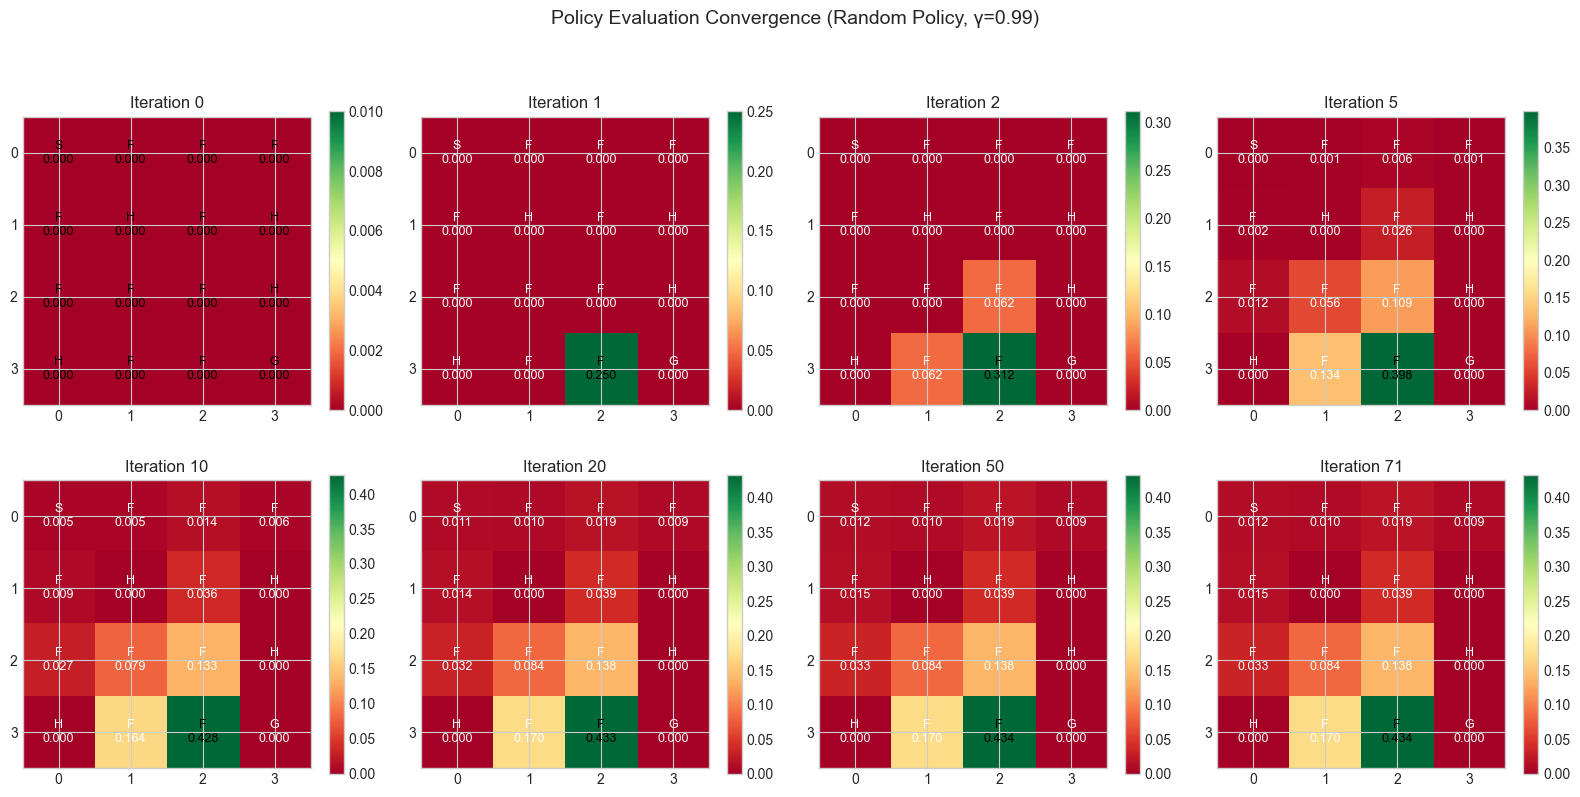

In [22]:
# Visualize the convergence of policy evaluation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

iterations_to_show = [0, 1, 2, 5, 10, 20, 50, len(history_random)-1]
iterations_to_show = [min(i, len(history_random)-1) for i in iterations_to_show]

for idx, (ax, it) in enumerate(zip(axes.flat, iterations_to_show)):
    V_it = history_random[it]
    plot_value_function(V_it, title=f"Iteration {it}", ax=ax)

plt.suptitle("Policy Evaluation Convergence (Random Policy, γ=0.99)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### How to Read This Plot

**Question this plot answers:** *"How does the value function evolve during Policy Evaluation?"*

**Understanding the visualization:**
- **8 heatmaps**: Each shows the value function V(s) at a different iteration (0, 1, 2, 5, 10, 20, 50, and final)
- **Grid cells**: Each cell represents one of the 16 states in FrozenLake
- **Colors**: Red-Yellow-Green scale where green = higher value, red = lower value
- **Numbers**: The actual V(s) value for each state
- **Letters**: S=Start, F=Frozen (safe), H=Hole (terminal, bad), G=Goal (terminal, good)

**What this shows:**
1. **Iteration 0**: All values start at 0 (our initialization)
2. **Early iterations (1-5)**: Values begin to emerge near the goal (state 15) and propagate backward
3. **Middle iterations (10-20)**: Value information spreads across the grid
4. **Final iteration (71)**: Converged values - states closer to the goal have higher values

**Key observations:**
- **Holes (H) and Goal (G)** always have V=0 because they are terminal states
- **State 14** (next to goal) has the highest value (~0.434) under random policy because it's one step from reward
- **State 0** (start) has low value (~0.012) under random policy - random walking rarely reaches the goal!
- **Value propagates backward** from the goal through the Bellman equation

**Why this matters:** This visualization shows that Policy Evaluation discovers which states are "good" (lead to reward) by iteratively propagating value information backward from rewarding states.

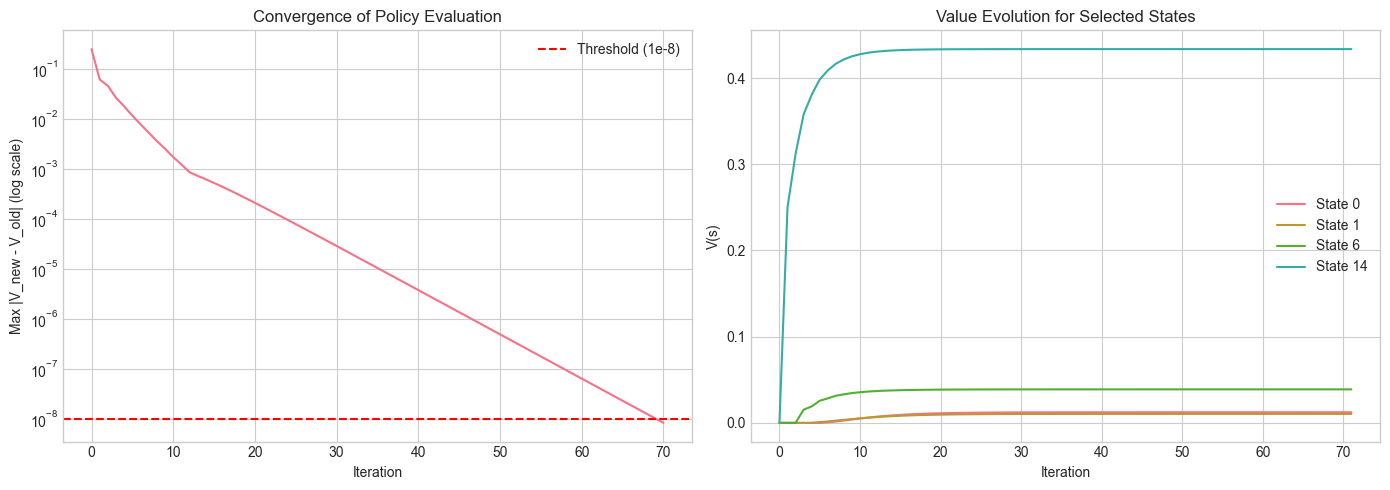

In [23]:
# Plot convergence curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Max change per iteration
deltas = [np.max(np.abs(history_random[i+1] - history_random[i])) 
          for i in range(len(history_random)-1)]
axes[0].semilogy(deltas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Max |V_new - V_old| (log scale)')
axes[0].set_title('Convergence of Policy Evaluation')
axes[0].axhline(y=1e-8, color='r', linestyle='--', label='Threshold (1e-8)')
axes[0].legend()

# Plot 2: Value of specific states over iterations
states_to_track = [0, 1, 6, 14]  # Start, near start, middle, near goal
for s in states_to_track:
    values = [history_random[i][s] for i in range(len(history_random))]
    axes[1].plot(values, label=f'State {s}')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('V(s)')
axes[1].set_title('Value Evolution for Selected States')
axes[1].legend()

plt.tight_layout()
plt.show()

### How to Read These Plots

**Question these plots answer:** *"How quickly does Policy Evaluation converge, and how do individual state values change?"*

**Left Plot - Convergence of Policy Evaluation:**
- **X-axis**: Iteration number (0 to ~70)
- **Y-axis**: Maximum change in value function (log scale)
- **Blue line**: Shows max|V_new - V_old| at each iteration
- **Red dashed line**: Convergence threshold (1e-8)

**What to observe:**
- The curve decreases roughly linearly on a log scale → **exponential convergence**
- Convergence happens when the blue line crosses below the red threshold
- Early iterations show large changes; later iterations refine small differences

**Right Plot - Value Evolution for Selected States:**
- **X-axis**: Iteration number
- **Y-axis**: V(s) value for each tracked state
- **Four lines**: Track states 0 (start), 1, 6 (middle), and 14 (near goal)

**What to observe:**
- **State 14** (near goal) reaches its final value fastest - it's closest to the reward source
- **State 0** (start) takes longest to stabilize - value must propagate through many states
- All states show the characteristic "rising then plateau" pattern of convergence
- States closer to the goal have higher final values

**Why this matters:** These plots demonstrate two key properties of iterative Policy Evaluation:
1. **Guaranteed convergence** - the algorithm always converges (blue line always decreases)
2. **Backward propagation** - value information flows from goal states backward through the MDP

---
# 3. Policy Improvement

**Problem**: Given a value function $V^\pi$, find a better policy $\pi'$.

## Approach: Greedy Policy

For each state, choose the action that maximizes expected return:

$$\pi'(s) = \arg\max_a \left[ R_s^a + \gamma \sum_{s'} P_{ss'}^a V^\pi(s') \right]$$

## Policy Improvement Theorem

If $\pi'$ is the greedy policy with respect to $V^\pi$, then:

$$V^{\pi'}(s) \geq V^\pi(s) \text{ for all } s$$

The new policy is at least as good as the old one!

In [24]:
def policy_improvement(P, R, V, gamma):
    """
    Compute greedy policy with respect to value function V.
    
    Args:
        P: Transition matrix
        R: Reward matrix
        V: Current value function
        gamma: Discount factor
    
    Returns:
        policy: New deterministic policy (one-hot encoded)
        Q: Action-value function
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    # Compute Q-values
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R[s, a] + gamma * np.sum(P[s, a] * V)
    
    # Create greedy policy
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        best_action = np.argmax(Q[s])
        policy[s, best_action] = 1.0
    
    return policy, Q

In [25]:
# Improve the random policy
print("Policy Improvement")
print("=" * 50)

improved_policy, Q = policy_improvement(P, R, V_random, gamma=0.99)

# Show the improved policy
print("\nImproved Policy (best action for each state):")
best_actions = np.argmax(improved_policy, axis=1).reshape(4, 4)
for i in range(4):
    row = [action_arrows[a] for a in best_actions[i]]
    print(f"  {row}")

Policy Improvement

Improved Policy (best action for each state):
  ['←', '↑', '←', '↑']
  ['←', '←', '←', '←']
  ['↑', '↓', '←', '←']
  ['←', '→', '↓', '←']


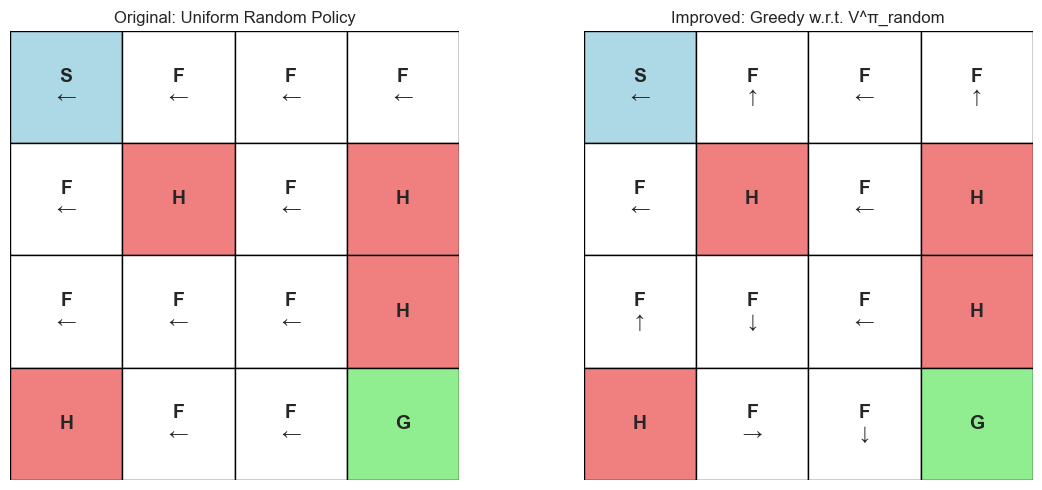

In [26]:
# Compare random and improved policies
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_policy(uniform_policy, title="Original: Uniform Random Policy", ax=axes[0])
plot_policy(improved_policy, title="Improved: Greedy w.r.t. V^π_random", ax=axes[1])

plt.tight_layout()
plt.show()

### How to Read This Plot

**Question this plot answers:** *"How does Policy Improvement change the agent's behavior?"*

**Understanding the visualization:**
- **Two grids side by side**: Original policy (left) vs Improved policy (right)
- **Cell colors**: S=Start (blue), F=Frozen (white), H=Hole (red), G=Goal (green)
- **Arrows**: Show the action the policy takes in each state (←↓→↑)
- **No arrows in H/G**: Terminal states have no actions

**Left Grid - Uniform Random Policy:**
- All arrows point in all 4 directions equally (shown as the first action by convention)
- The agent has no preference - it randomly picks LEFT, DOWN, RIGHT, or UP with equal probability
- This is our starting point before any learning

**Right Grid - Improved (Greedy) Policy:**
- Each arrow shows the **single best action** according to Q-values computed from V^π_random
- The policy is now **deterministic** - one specific action per state
- Arrows generally point toward higher-value regions (toward the goal)

**Key observations:**
- **State 14** (F, bottom row, second from right): Points ↓ toward the Goal
- **State 10** (F, third row): Points ← toward state 9, which has higher value
- **Some actions may seem counterintuitive** due to the slippery ice - the "best" action accounts for slip probabilities

**Why this matters:** This visualization shows the core idea of Policy Improvement - by computing Q-values and acting greedily, we transform a random policy into a directed, purposeful one. The improved policy should achieve higher returns (verified in the next cell).

In [27]:
# Evaluate the improved policy to verify it's better
V_improved, _ = policy_evaluation(P, R, improved_policy, gamma=0.99)

print("\nComparison of Value Functions")
print("=" * 50)
print(f"{'State':<8} {'V_random':>12} {'V_improved':>12} {'Improvement':>12}")
print("-" * 50)
for s in range(n_states):
    diff = V_improved[s] - V_random[s]
    print(f"{s:<8} {V_random[s]:>12.4f} {V_improved[s]:>12.4f} {diff:>12.4f}")

print(f"\nTotal improvement: {np.sum(V_improved - V_random):.4f}")
print(f"All states improved or same: {np.all(V_improved >= V_random - 1e-10)}")

Policy Evaluation converged in 370 iterations (delta=9.74e-09)

Comparison of Value Functions
State        V_random   V_improved  Improvement
--------------------------------------------------
0              0.0124       0.5325       0.5201
1              0.0104       0.4498       0.4394
2              0.0193       0.3807       0.3614
3              0.0095       0.3695       0.3601
4              0.0148       0.5486       0.5338
5              0.0000       0.0000       0.0000
6              0.0389       0.3232       0.2843
7              0.0000       0.0000       0.0000
8              0.0326       0.5814       0.5488
9              0.0843       0.6318       0.5474
10             0.1378       0.5987       0.4609
11             0.0000       0.0000       0.0000
12             0.0000       0.0000       0.0000
13             0.1703       0.7344       0.5640
14             0.4336       0.8592       0.4256
15             0.0000       0.0000       0.0000

Total improvement: 5.0458
All states i

---
# 4. Policy Iteration

**Policy Iteration** alternates between:
1. **Policy Evaluation**: Compute $V^\pi$ for current policy
2. **Policy Improvement**: Make policy greedy with respect to $V^\pi$

Repeat until the policy no longer changes (converges to optimal policy $\pi^*$).

## Algorithm

```
1. Initialize policy π arbitrarily
2. Repeat:
   a. Policy Evaluation: Compute V^π
   b. Policy Improvement: π' = greedy(V^π)
   c. If π' = π, stop (converged)
   d. π = π'
3. Return π* and V*
```

## Convergence

Policy iteration is guaranteed to converge to the optimal policy in a finite number of iterations (since there are finite deterministic policies).

In [28]:
def policy_iteration(P, R, gamma, theta=1e-8, max_iterations=100):
    """
    Policy Iteration algorithm.
    
    Args:
        P: Transition matrix
        R: Reward matrix
        gamma: Discount factor
        theta: Convergence threshold for policy evaluation
        max_iterations: Maximum policy improvement iterations
    
    Returns:
        policy: Optimal policy
        V: Optimal value function
        policy_history: List of policies at each iteration
        V_history: List of value functions at each iteration
    """
    n_states = P.shape[0]
    n_actions = P.shape[1]
    
    # Initialize with random policy
    policy = np.ones((n_states, n_actions)) / n_actions
    
    policy_history = [policy.copy()]
    V_history = []
    
    for iteration in range(max_iterations):
        # Policy Evaluation
        V, _ = policy_evaluation(P, R, policy, gamma, theta=theta)
        V_history.append(V.copy())
        
        # Policy Improvement
        new_policy, Q = policy_improvement(P, R, V, gamma)
        
        # Check if policy changed
        if np.array_equal(new_policy, policy):
            print(f"Policy Iteration converged in {iteration + 1} iterations")
            break
        
        policy = new_policy
        policy_history.append(policy.copy())
    
    return policy, V, policy_history, V_history

In [29]:
# Run Policy Iteration
print("Running Policy Iteration")
print("=" * 50)

start_time = time.time()
optimal_policy_pi, V_star_pi, policy_history, V_history = policy_iteration(P, R, gamma=0.99)
pi_time = time.time() - start_time

print(f"\nTime taken: {pi_time:.4f} seconds")
print(f"\nOptimal Value Function V*:")
print(V_star_pi.reshape(4, 4).round(4))

Running Policy Iteration
Policy Evaluation converged in 71 iterations (delta=8.30e-09)
Policy Evaluation converged in 370 iterations (delta=9.74e-09)
Policy Evaluation converged in 441 iterations (delta=9.73e-09)
Policy Iteration converged in 3 iterations

Time taken: 0.1021 seconds

Optimal Value Function V*:
[[0.542  0.4988 0.4707 0.4569]
 [0.5585 0.     0.3583 0.    ]
 [0.5918 0.6431 0.6152 0.    ]
 [0.     0.7417 0.8628 0.    ]]


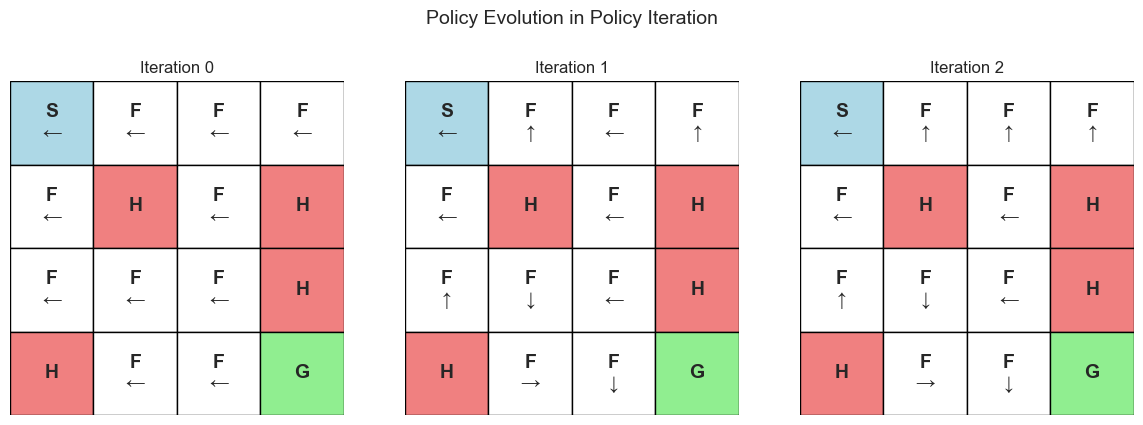

In [30]:
# Visualize policy evolution
n_policies = len(policy_history)
fig, axes = plt.subplots(1, min(n_policies, 5), figsize=(4*min(n_policies, 5), 4))

if n_policies == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    if i < n_policies:
        plot_policy(policy_history[i], title=f"Iteration {i}", ax=ax)

plt.suptitle("Policy Evolution in Policy Iteration", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### How to Read This Plot

**Question this plot answers:** *"How does the policy change during Policy Iteration?"*

**Understanding the visualization:**
- **Multiple grids**: Each shows the policy at one iteration of Policy Iteration
- **Iteration 0**: Starting policy (uniform random - all actions equally likely)
- **Subsequent iterations**: Policy after each improvement step
- **Arrows**: The best action (highest probability) in each state

**What to observe:**
1. **Iteration 0** (random): Arrows appear arbitrary (showing first action due to ties)
2. **Iteration 1**: First improvement - arrows start pointing toward goal region
3. **Iteration 2**: Further refinement - policy becomes more coherent
4. **Final iteration**: Optimal policy π* - arrows show the best path to goal

**Key insight - Fast convergence:**
- Policy Iteration typically converges in just **3-5 iterations** for FrozenLake
- This is much fewer than the ~70 iterations needed for each Policy Evaluation step
- Why? Each improvement step makes a **large jump** toward optimality

**Tracing an optimal path:**
Starting from S (state 0), follow the arrows:
- The arrows guide you toward the goal while avoiding holes
- Due to slippery ice, the actual path will vary, but this policy maximizes success probability

**Why this matters:** This visualization demonstrates the remarkable efficiency of Policy Iteration - despite the large space of possible policies (4^16 ≈ 4 billion), the algorithm finds the optimal one in just a few steps by making greedy improvements.

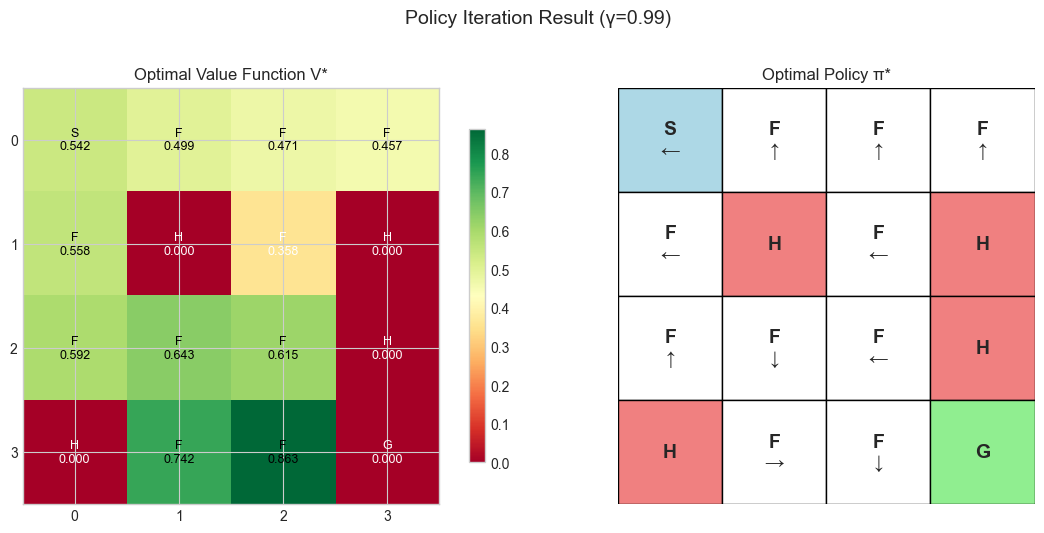

In [31]:
# Visualize final optimal policy and value function
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_value_function(V_star_pi, title="Optimal Value Function V*", ax=axes[0])
plot_policy(optimal_policy_pi, title="Optimal Policy π*", ax=axes[1])

plt.suptitle("Policy Iteration Result (γ=0.99)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### How to Read These Plots

**Question these plots answer:** *"What is the optimal value function and policy for FrozenLake?"*

**Left Plot - Optimal Value Function V\*:**
- **Heatmap colors**: Green = high value, Red = low value
- **Numbers**: V*(s) for each state - the expected return when acting optimally from that state
- **Terminal states** (H and G): Always 0 (no future rewards possible)

**Interpreting V* values:**
- **State 14** (V*=0.863): Very high - one optimal move from the goal!
- **State 0** (V*=0.542): The starting state has ~54% expected return under optimal play
- **States near holes**: Lower values due to risk of falling in
- **Pattern**: Values generally increase as you get closer to the goal

**Right Plot - Optimal Policy π\*:**
- **Arrows**: The single best action in each state
- **Following arrows**: Traces the optimal path(s) to the goal

**Key observations about π\*:**
- Arrows generally guide toward the goal while avoiding holes
- **State 6**: Points ← (LEFT) to avoid the holes at states 5 and 7
- **State 10**: Points ↓ (DOWN) toward state 14, then goal
- **State 14**: Points ↓ (DOWN) directly to the goal

**Why values aren't higher:**
Even with the optimal policy, V*(start) ≈ 0.54 (not 1.0) because:
1. The ice is **slippery** - you only go in your intended direction 1/3 of the time
2. There's always risk of slipping into a hole
3. The ~74% success rate (from empirical testing) matches these theoretical values

**Comparing to random policy:**
- Random policy: V(start) ≈ 0.012 (about 1% success)
- Optimal policy: V*(start) ≈ 0.542 (about 54% expected return)
- **Improvement: ~44x better!** This is the power of Policy Iteration.

---
# 5. Summary and Concept Map

In this notebook, we learned the foundation of Policy-Based Dynamic Programming:

```
POLICY-BASED DYNAMIC PROGRAMMING
=================================

Requirements: Complete knowledge of MDP (S, A, P, R, γ)
Goal: Find optimal policy π*
────────────────────────────────────────────────────


POLICY EVALUATION
─────────────────
Problem: Given policy π, compute V^π(s)

Algorithm: Iterative application of Bellman expectation equation
V_{k+1}(s) = Σ π(a|s) [R^a_s + γ Σ P^a_{ss'} V_k(s')]

Convergence: V_k → V^π as k → ∞

Use case: Evaluate how good a policy is


POLICY IMPROVEMENT
──────────────────
Problem: Given V^π, find better policy π'

Algorithm: Greedy policy selection
π'(s) = argmax_a [R^a_s + γ Σ P^a_{ss'} V^π(s')]

Guarantee: V^{π'}(s) ≥ V^π(s) for all s

Use case: Make a policy better


POLICY ITERATION
────────────────
Problem: Find optimal policy π*

Algorithm: Alternate two steps
1. Policy Evaluation: Compute V^π for current policy π
2. Policy Improvement: Update π greedily w.r.t. V^π
   π'(s) = argmax_a [R^a_s + γ Σ P^a_{ss'} V^π(s')]

Convergence: Finite iterations (each improvement strictly better)
               π_0 → π_1 → ... → π*

Efficiency: Fewer iterations but more computation per iteration


THE FLOW
────────

  ┌─────────────────┐
  │  Start: π₀      │
  │  (any policy)   │
  └────────┬────────┘
           │
           ▼
  ┌─────────────────┐
  │ Policy          │
  │ Evaluation      │◄────────┐
  │ Compute V^π     │         │
  └────────┬────────┘         │
           │                  │
           ▼                  │
  ┌─────────────────┐         │
  │ Policy          │         │
  │ Improvement     │         │
  │ π' = greedy(V)  │         │
  └────────┬────────┘         │
           │                  │
           ▼                  │
     ┌───────────┐            │
     │ π' = π ?  │──No───────┘
     └─────┬─────┘
           │Yes
           ▼
  ┌─────────────────┐
  │  Done: π* = π   │
  │  (optimal)      │
  └─────────────────┘
```

## What's Next?

In the next notebook (**03_2_value_iteration.ipynb**), we'll learn:
- **Value Iteration**: A different approach that applies the Bellman optimality equation directly
- **Comparison**: Policy Iteration vs Value Iteration - when to use each
- **Empirical Evaluation**: Testing optimal policies on the actual environment
- **Effect of Discount Factor**: How γ affects the optimal policy

## Key Takeaways

1. **DP requires full model knowledge** - we need P and R
2. **Policy Evaluation**: Compute V^π by iterating the Bellman expectation equation
3. **Policy Improvement**: Make policy greedy with respect to V^π
4. **Policy Iteration**: Alternates evaluation and improvement, guaranteed to converge
5. **Convergence**: Policy Iteration finds π* in finite iterations

---
# 6. Your Turn

Now it's time to test your understanding with some hands-on exercises!

## Exercise 1: Implement Policy Evaluation for a Custom Policy

Modify the policy evaluation code to evaluate a "safe" policy that tries to avoid holes.

**Task**: Complete the code below to implement policy evaluation for this custom policy:

In [32]:
# YOUR CODE HERE
# Define a policy that goes DOWN in top half, RIGHT in bottom half

def create_safe_policy():
    """
    Create a deterministic policy trying to stay safe:
    - Top half (rows 0-1): Always go DOWN
    - Bottom half (rows 2-3): Always go RIGHT
    
    Returns: policy matrix π[s,a] (probabilities)
    """
    policy = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        row = s // 4
        col = s % 4
        
        # TODO: Implement the policy
        # Hint: Use row to decide action
        # If row < 2 (top half): set policy[s, 1] = 1.0 (DOWN)
        # If row >= 2 (bottom half): set policy[s, 2] = 1.0 (RIGHT)
        
        pass  # Replace with your implementation
    
    return policy

# TODO: Create the safe policy and evaluate it
# safe_policy = create_safe_policy()
# V_safe, _ = policy_evaluation(P, R, safe_policy, gamma=0.99)

# TODO: Compare V values to random policy
# print(f"Safe policy V(start): {V_safe[0]:.4f}")
# print(f"Random policy V(start): {V_random[0]:.4f}")

<details>
<summary>Click to see hint</summary>

Use the row number to determine action:
- If row < 2 (top half): action DOWN (index 1)
- If row >= 2 (bottom half): action RIGHT (index 2)

Set the appropriate action probability to 1.0 in each row of the policy matrix.

</details>

<details>
<summary>Click to see solution</summary>

```python
def create_safe_policy():
    """Create the safe policy as a matrix."""
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        row = s // 4
        if row < 2:
            policy[s, 1] = 1.0  # DOWN
        else:
            policy[s, 2] = 1.0  # RIGHT
    return policy

# Evaluate the safe policy
safe_policy = create_safe_policy()
V_safe, _ = policy_evaluation(P, R, safe_policy, gamma=0.99)

print(f"Safe policy V(start): {V_safe[0]:.4f}")
print(f"Compare to random policy: {V_random[0]:.4f}")

# The safe policy should have higher value at the start state!
```

</details>

## Exercise 2: Conceptual Question - Policy Iteration

**Question**: Why does Policy Iteration guarantee convergence to the optimal policy in a finite number of iterations?

<details>
<summary>Click to see hint</summary>

Think about:
- How many deterministic policies exist for a finite MDP?
- What happens to V^π after each policy improvement step?
- Can the algorithm cycle back to a previous policy?

</details>

<details>
<summary>Click to see answer</summary>

**Policy Iteration converges in finite iterations because:**

1. **Finite policies**: For a finite MDP with |S| states and |A| actions, there are at most |A|^|S| deterministic policies. For FrozenLake: 4^16 ≈ 4 billion policies.

2. **Monotonic improvement**: The Policy Improvement Theorem guarantees that V^{π'}(s) ≥ V^π(s) for all states. Each improvement step makes the policy strictly better (or equal if already optimal).

3. **No cycling**: Since values can only increase and there are finite policies, the algorithm cannot revisit a previous policy. It must eventually reach a policy where no improvement is possible.

4. **Termination**: When π' = π (no change), we've found a policy that is greedy with respect to its own value function. This is the definition of an optimal policy!

**In practice**, Policy Iteration converges in very few iterations (often 5-10) because each improvement step makes significant progress toward optimality.

</details>

---

Congratulations! You've completed Part 3.1 of the RL Tutorial!

Key takeaways:
- Policy Evaluation: Iteratively compute V^π using Bellman expectation
- Policy Improvement: Make policy greedy w.r.t. current V
- Policy Iteration: Alternate eval and improvement until convergence
- Policy Iteration finds the optimal policy in finite iterations

Next: 03_2_value_iteration.ipynb